<p style="font-size:28px;font-weight:bold;">Module 6.2 - Convolutional Neural Networks for LPC Data</p>
This module applies the concept of Convolutional Neural Networks as discussed in Module 6 to LPC data</br></br>
The first thing, below, is a class, <span style="color:green;font-weight:bold;">class</span> <span style="color:blue;font-weight:bold">LPCDataset</span>, that mimics the <span style="color:blue;font-weight:bold">CCDataset</span> class from Module 6, but is modified to load the 2D dataset.

In [1]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import torch

class LPCDataset(Dataset):
    def __init__(self, labels, datafile, inds, transform=None, target_transform=None):
        self.labels = np.asarray([item if item<3 else item-1 for item in np.load(labels)], dtype="int")
        self.data = np.load(datafile).astype(np.float32);
        self.transform = transform
        self.target_transform = target_transform
        self.indices = inds;

    def __len__(self):
        return len(self.indices);

    def __getitem__(self, idx):
        dat = self.data[self.indices[idx]][:];
        if self.transform:
            dat = self.transform(dat);
        else:
            dat = torch.as_tensor(dat).unsqueeze(0);
        if self.target_transform:
            dat = self.target_transform(dat);
        return dat, self.labels[self.indices[idx]];

In [2]:
labels = np.load("Labels_aug.npy");

In [3]:
import random
trainInds = random.sample(range(len(labels)),round(len(labels)*0.9));
testInds = [item for item in random.sample(range(len(labels)),round(len(labels))) if item not in trainInds];

In [4]:
from torchvision.transforms import ToTensor
LPC_train_data = LPCDataset("Labels_aug.npy","2D_LPC_aug.npy", trainInds);
LPC_test_data = LPCDataset("Labels_aug.npy","2D_LPC_aug.npy", testInds);

<p>As seen below, the batch size was increased from 3 to 6 to try and maximize performance</p>

In [5]:
from torch.utils.data import DataLoader
batch_size = 6

# Create data loaders.
LPC_train_dataloader = DataLoader(LPC_train_data, batch_size=batch_size)
LPC_test_dataloader = DataLoader(LPC_test_data, batch_size=batch_size)

for X, y in LPC_train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print("N = batch size. This is the number of images to process at a time.")
    print("C = number of channels. C=1 for grayscale. C=3 for RGB.")
    print("H = height is the number of rows in the image.")
    print("W = width is the number of columns in the image.")
    print(" ")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print("y is of size N, the ground truth labels required for each image in the batch.")
    print(y)
    break

train_size = len(LPC_train_dataloader.dataset)
test_size  = len(LPC_test_dataloader.dataset)
train_pct  = 100*train_size/(train_size+test_size)
test_pct   = 100*test_size/(train_size+test_size)
print(f"Percentage of training dataset = {train_pct:.2f} percent with {train_size} samples.")
print(f"Percentage of test dataset     = {test_pct:.2f} percent with {test_size} samples.")

Shape of X [N, C, H, W]: torch.Size([6, 1, 14]) torch.float32
N = batch size. This is the number of images to process at a time.
C = number of channels. C=1 for grayscale. C=3 for RGB.
H = height is the number of rows in the image.
W = width is the number of columns in the image.
 
Shape of y: torch.Size([6]) torch.int64
y is of size N, the ground truth labels required for each image in the batch.
tensor([1, 1, 4, 7, 5, 2])
Percentage of training dataset = 90.01 percent with 2479 samples.
Percentage of test dataset     = 9.99 percent with 275 samples.


In [18]:
print(f"Expected: \t{classes[labels[trainInds[1]].astype('int')]}\nFrom Dataset: \t{classes[LPC_train_data.__getitem__(1)[1]]}");

Expected: 	Pump 1 Run
From Dataset: 	Pump 1 Run


In [7]:
classes = ["Pump 1 Start", "Pump 1 Run", "Pump 1 Stop", "Pump 2 Start", "Pump 2 Run", "Pump 2 Stop", "Pump 3 Start", "Pump 3 Run", "Pump 3 Stop", "Pump 4 Start", "Pump 4 Run", "Pump 4 Stop"];

<p>The following model is a moderate departure from the model seen in Module 6. As will be seen later, the extremely small number of observations for each sample in the Order 13 LPC dataset drastically limited performance of the CNN training. By attempting to reduce the number of weights through trimming the model, the hope was to improve the accuracy of the fit</p>

In [8]:
from torch import nn
import math
import torch.nn.functional as F
class Test_LPC_CNN(nn.Module):
    def __init__(self, num_of_rows = 1, num_of_cols = 14,
                 n_filters1=4, n_filters2=8, out_categories=12):
        super().__init__()

        self.conv1 = nn.Conv1d(
                in_channels=1,            # 1 for grayscale
                out_channels=n_filters1,   # Number of filters
                kernel_size=2,            # 3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )
        self.pool = nn.MaxPool1d(2)  # halves size to 14x14
        
        self.drop = nn.Dropout1d(p=0.25);

        # out_categories should match the number of output categories.
        # Match the dimensions to the input.
        # Divide by 2 for each maxpooling (carefull for non-even numbers ...)
        num_of_pixels = math.floor(num_of_cols/(2*2))

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_of_cols*2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
        )

        # Final layer collects the pixels from all of the inputs:
        self.fc1 = nn.Linear(32, out_categories)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 
        x = self.drop(x);                     # -> 
        x = x.view(x.size(0), -1)             # flatten
        x = self.linear_relu_stack(x);
        logits = F.relu(self.fc1(x))
        return logits # Note: SoftMax is applied to logits by cross-entropy loss function.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#device = "cpu"
torch.cuda.empty_cache()
model = Test_LPC_CNN(n_filters1=4, n_filters2=8).to(device)

In [9]:
def parameter_report(model):
    print(f"{'Layer':<40} {'# Params':>12} {'Trainable':>10}")
    print("-" * 65)
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        is_trainable = param.requires_grad
        print(f"{name:<40} {num_params:>12,} {str(is_trainable):>10}")
        total += num_params
        if is_trainable:
            trainable += num_params
    print("-" * 65)
    print(f"{'Total':<40} {total:>12,} {'':>10}")
    print(f"{'Trainable':<40} {trainable:>12,}")


print(model)
print(" ")

parameter_report(model)

Test_LPC_CNN(
  (conv1): Conv1d(1, 4, kernel_size=(2,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.25, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=28, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc1): Linear(in_features=32, out_features=12, bias=True)
)
 
Layer                                        # Params  Trainable
-----------------------------------------------------------------
conv1.weight                                        8       True
conv1.bias                                          4       True
linear_relu_stack.0.weight                        896       True
linear_relu_stack.0.bias                           32       True
linear_relu_stack.2.weight                      1,024       True
linear_relu_stack.2.bias                           32       True
fc1.weight                   

<p>The number of trainable parameters seen above is substantially fewer than that of the MFCC or LFCC focused models.</p>
<p>The following training and test functions are mostly identical to that of the Module 6 code</p>

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
from torch.optim.lr_scheduler import LRScheduler
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ExponentialLR
import gc

def train(dataloader, model, loss_fn, optimizer, epochs):
    size = len(dataloader.dataset)
    model.train() # Put the model in training mode.
    scheduler1 = ExponentialLR(optimizer, gamma=0.9)
    scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    print(f"  0%[{20*" "}]\r",end="");
    loss_last = 0;
    twice = False;
    for ep in range(epochs):
        test_loss, num = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            # Place the model and predictions on the same device.
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item();
            num+=1;
    
            # Backpropagation
            # This step updates the parameter values inside your network.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            del X, y, pred;
            torch.cuda.empty_cache()
        if (loss_last - (test_loss/num)  < 0.005 and loss_last - (test_loss/num) > 0):
            if twice:
                break;
            else:
                twice = True;
        else:
            loss_last = test_loss/num;
        
        #print(f"loss: {test_loss/num:>7f}")
        print(f"{100*(ep/epochs):3.0f}%[{int(20 * ep/epochs)*"■"}{(20-int(20 * ep/epochs))*" "}]\r",end="");   # Print a progress bar. A number of blocks are printed based on the percentage through the count of epochs
        # Step the learning rate schedulers based on the current status
        scheduler1.step();
        scheduler2.step();
    print(f"100%[{20*"■"}]\r");        # We need to make sure to jump the progress bar to 100% at the end, especially if we broke early due to small enough change in loss

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in testing mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

<p>The performance expected below is poor. This model is not a good fit for this dataset, and does not perform satisfactorily</p>

In [13]:
train(LPC_train_dataloader, model, loss_fn, optimizer, 100);
test(LPC_test_dataloader, model, loss_fn)

100%[■■■■■■■■■■■■■■■■■■■■]
Test Error: 
 Accuracy: 16.4%, Avg loss: 2.386956 



In [14]:
test(LPC_train_dataloader,model,loss_fn)

Test Error: 
 Accuracy: 17.3%, Avg loss: 2.393930 



In [15]:
torch.save(model.state_dict(), "LPC.pth")

<p>We can do some quick checking of the performance with the a random sample followed by ROC curves</p>

In [16]:
# Put the model in evaluation mode.
model.eval()

# Grab a test index
test_index = 105
x, y = LPC_test_data[test_index]

img  = x.squeeze()

with torch.no_grad():
    x = x.to(device)

    pred = model(x.unsqueeze(0)) # Create a batch size = 1 using unsqueeze()

    print("Outputs for all categories:")
    print(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Outputs for all categories:
tensor([[0.0407, 0.0000, 0.0000, 0.0000, 0.0000, 0.9902, 0.8140, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]], device='cuda:0')
Predicted: "Pump 2 Stop", Actual: "Pump 3 Run"


C:\Users\374177\AppData\Local\anaconda3\envs\project-env\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


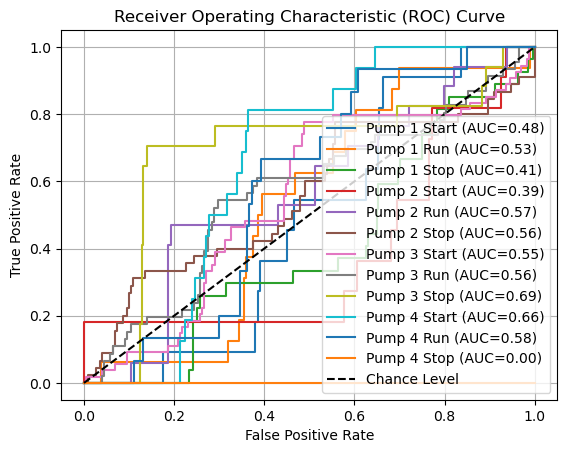

In [17]:
from torchmetrics.classification import ROC
from torchmetrics.classification import AUROC
import matplotlib.pyplot as plt

model.eval()
pred = 0;
for i in range(len(testInds)):
    # Grab a test index
    x, y_inst = LPC_test_data[i]
    with torch.no_grad():
        x = x.to(device)
        if type(pred)==int:
            pred = model(x.unsqueeze(0))
            y = y_inst;
        else:
            pred = torch.cat((pred,model(x.unsqueeze(0))),dim=0);
            y = np.append(y, y_inst);
y = torch.as_tensor(y).to(device);

roc_metric = ROC(task="multiclass", num_classes=12)
roc_metric.update(pred, y)
fpr, tpr, thresholds = roc_metric.compute()

AUC = AUROC(task="multiclass", num_classes=12, average=None)
AUC.update(pred, y)
AUCs = AUC.compute()
#print(f"Aggregate ROC AUC: {AUCs[0].cpu().numpy():.4f}")


plt.figure()
for i in range(12):
    plt.plot(fpr[i].cpu(), tpr[i].cpu(), label=f"{classes[i]} (AUC={AUCs[i].cpu().numpy():.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level") # dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

<p>As seen above, this model performs quite poorly. Some classes perform ok, occasionally getting AUC scores in excess of 0.7, but others can do as poorly as 0.00</p>